# HOPPS: hardware-aware optimal phase polynomial synthesis

**HOPPS** is a *hardware-aware optimal phase polynomial synthesis tool*. It computes optimal solutions using a SAT solver, supporting both CNOT count and CNOT depth minimization.

To run the tool, follow these steps:

1. **Define a logical circuit** composed of `{CNOT, R_z}` gates.  
2. **Mapping a circuit** (e.g., Qiskit) to a device.  
3. **Optimizing the Mapped Circuit** by using HOPPS to do hardware-aware resynthesis.

In the following, we provide examples on QAOA and general circuits to demonstrate how to use HOPPS.

### Synthesis small QAOA circuit
#### Read a logical QAOA circuit

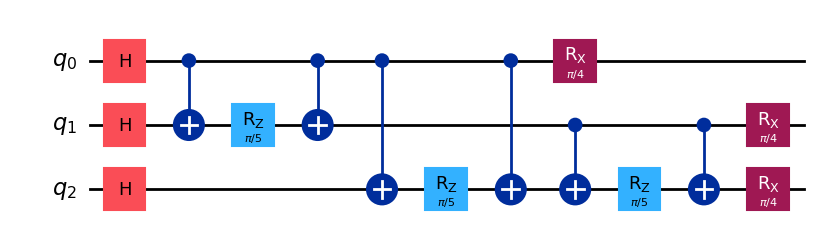

In [1]:
from src.util import read_circuit_qiskit

# Number of qubit
n_qubit = 3

# Number of terms (like 'IZZI')
k = 3

# Logical Quantum Circuit
file = "benchmark/MaxCut_Random/logical/"+"Random"+ str(n_qubit) +"_"+ str(k) +"_logical_circuit.qpy"

qc, name = read_circuit_qiskit(file)

qc.draw()


#### Strip circuit into `{CNOT, R_z}` circuit

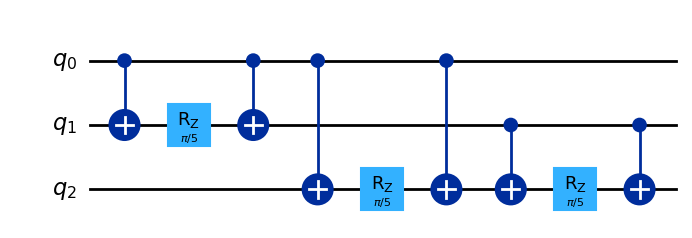

In [2]:
from qiskit import QuantumCircuit
from src.util import strip_qaoa_circuit
    
qc = strip_qaoa_circuit(qc)
qc.draw()

#### Extract phase polynomial representation from circuit

In [3]:
from src.util import extract_parity_from_circuit_custom

output_parity, term_parity, params = extract_parity_from_circuit_custom(qc)

#### Mapping the circuit using qiskit

In [ ]:
import json
from qiskit import transpile
from qiskit.transpiler import CouplingMap
from src.util import qiskit_initial_layout

sub_coupling_maps = qiskit_initial_layout(qc, "melbourne")
        

#### Using HOPPS to get optimal solution

In [5]:
from src import z3_sat_solve_free_output

input_parity = [[True if i == j else False for j in range(n_qubit)] for i in range(n_qubit)]

# Systhesis the circuit
systhesis_circuit,_ = z3_sat_solve_free_output(n_qubit, 
                                                sub_coupling_maps, 
                                                term_parity, 
                                                input_parity, 
                                                output_parity, 
                                                params,
                                                cnot_or_depth='cnot', 
                                                max_k =  20,
                                                display = True)

Elapsed time: 0.002632 seconds
No solution found for 1
Elapsed time: 0.009633 seconds
No solution found for 2
Elapsed time: 0.002480 seconds
No solution found for 3
Elapsed time: 0.003124 seconds
No solution found for 4
Elapsed time: 0.003829 seconds
No solution found for 5
Elapsed time: 0.008152 seconds
solution found for 6current depth: 6
Try 5 depth, fail


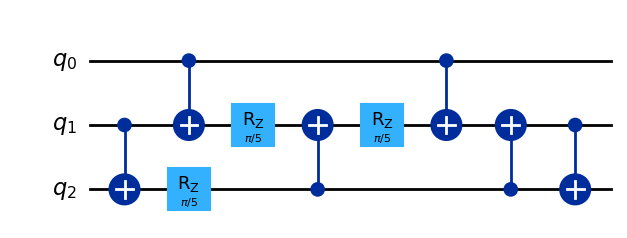

In [6]:
systhesis_circuit.draw()

### For general circuits
We skip the mapping process, direct read mapped result from benchmark https://github.com/irfansha/Q-Synth/tree/main/Benchmarks/ECAI-24/permuted_mapped. 
#### Optimizing the circuit

In [7]:
import os
import json
from qiskit import QuantumCircuit

# Get hardware constrains (Note: is should be same size as circuit; allow to have ancilla qubit in the circuit)
with open("Coupling_maps/melbourne.json", "r") as f:
    coupling_map = json.load(f)

# Get a mapped circuit
path = 'benchmark/permuted_mapped/tof_5.qasm'
qc = QuantumCircuit.from_qasm_file(path)

# Use sat optimization
from src import block_opt_general
opt_qc = block_opt_general(qc, 
                           coupling_map, 
                           cnot_or_depth='cnot', # two options: cnot optimal or depth optimal
                           block_size=8, # max number of qubit for each block
                           max_depth=15, # max depth allow for each block
                           method = 'phasepoly',
                           display = False) # 'phasepoly' or 'cnot'

#### Checking Performance

In [8]:
from qiskit import transpile
basis_gates = ['id', 'rz', 'cx', 'reset','h','rx']
transpiled_qc = transpile(qc, 
                        basis_gates = basis_gates, 
                        coupling_map = coupling_map, 
                        initial_layout = [i for i in range(qc.num_qubits)],
                        optimization_level=3)

transpiled_opt_qc = transpile(opt_qc, 
                        basis_gates = basis_gates, 
                        coupling_map = coupling_map, 
                        initial_layout = [i for i in range(qc.num_qubits)],
                        optimization_level=3)

from src.util import strip_circuit, remove_gates, swap_to_cnot, get_layout_from_circuit

print('Count/Depth')

print(qc.count_ops()['cx'] + 3*qc.count_ops()['swap'], strip_circuit(qc).depth(), '-> Orginial Mapped Quantum Circuit')

print(transpiled_qc.count_ops()['cx'], strip_circuit(transpiled_qc).depth(), '-> Orginial Mapped Quantum Circuit + qiskit L3')

print(opt_qc.count_ops()['cx'], strip_circuit(opt_qc).depth(), '-> Orginial Mapped Quantum Circuit + HOPPS-Cnot')

print(transpiled_opt_qc.count_ops()['cx'], strip_circuit(transpiled_opt_qc).depth(), '-> Orginial Mapped Quantum Circuit + HOPPS-Cnot + qiskit L3')

Count/Depth
80 71 -> Orginial Mapped Quantum Circuit
90 76 -> Orginial Mapped Quantum Circuit + qiskit L3
66 52 -> Orginial Mapped Quantum Circuit + HOPPS-Cnot
63 49 -> Orginial Mapped Quantum Circuit + HOPPS-Cnot + qiskit L3


#### Circuits Verify (Optional)

To verify circuit equivalence, we insert two random circuits—one before and one after—around both the original and the optimized circuits. Two circuits are considered equivalent if, for any input state, they produce the same output under any measurement basis. We use qiskit_aer to simulate the output probability distributions and compute the fidelity between the two circuits. You can run the verification multiple times to observe the fidelity across different randomizations.

In [9]:
from util import evaluate_circuit, calculate_fidelity
from qiskit.circuit.random import random_circuit

random_qc1 = random_circuit(qc.num_qubits, 20)

random_qc2 = random_circuit(qc.num_qubits, 20)

qc1 = QuantumCircuit(qc.num_qubits)
qc1 = random_qc1.compose(qc)
qc1 = qc1.compose(random_qc2)

qc2 = QuantumCircuit(qc.num_qubits)
qc2 = random_qc1.compose(opt_qc)
qc2 = qc2.compose(random_qc2)

prob1 = evaluate_circuit(qc1, 2**20)

prob2 = evaluate_circuit(qc2, 2**20)

calculate_fidelity(prob1, prob2)


np.float64(0.9997438219220756)

# HOPPS Iterative Blockwise Optimization

#### Read a QAOA circuit

In [1]:
from src import z3_sat_solve_free_output
from qiskit import QuantumCircuit
from src.util import read_circuit_qiskit

# Number of qubit
n_qubit = 16

# Number of terms (like 'IZZI')
k = 4

# Logical Quantum Circuit
file = "benchmark/MaxCut_Regular/logical/"+"Regular"+ str(n_qubit) +"_"+ str(k) +"_logical_circuit.qpy"
qc, name = read_circuit_qiskit(file)

#### Mapping the circuit using qiskit

In [2]:
from src.util import qiskit_initial_layout, qiskit_mapped_circuit

sub_coupling_maps = qiskit_initial_layout(qc, "kyiv")

transpiled_qc = qiskit_mapped_circuit(qc, sub_coupling_maps)
# transpiled_qc.draw()

#### Iteratively blockwise optimize the circuit

In [3]:
from src.blockwise_opt import block_opt_qaoa
from src.util import strip_circuit, strip_qaoa_circuit, two_direct_coupling_map
max_run = 10
cnot_or_depth = 'depth'

import time
td_coupling_map = two_direct_coupling_map(sub_coupling_maps)
opt_qc = strip_qaoa_circuit(transpiled_qc)
last_run_cnot = opt_qc.count_ops()['cx']
last_run_depth = strip_circuit(opt_qc).depth()
for i in range(int(max_run/2)):
    start_time = time.time()
    opt_qc = block_opt_qaoa(opt_qc, coupling_map=td_coupling_map,cnot_or_depth=cnot_or_depth, max_depth=20, block_size =5, display=False)
    if cnot_or_depth == 'cnot' and last_run_cnot == opt_qc.count_ops()['cx']:
            break
    elif cnot_or_depth == 'depth' and last_run_depth == strip_circuit(opt_qc).depth():
            break
    end_time = time.time() 
    print('iteration_time:', i,'time',end_time - start_time)    
    print('iteration_time:', i, opt_qc.count_ops()['cx'], strip_circuit(opt_qc).depth())
    last_run_cnot = opt_qc.count_ops()['cx']
    last_run_depth = strip_circuit(opt_qc).depth()

for i in range(max_run - int(max_run/2)):
    start_time = time.time()
    opt_qc = block_opt_qaoa(opt_qc, coupling_map=td_coupling_map,cnot_or_depth=cnot_or_depth, block_size=4, method='Cluster', display=False)
    end_time = time.time() 
    print('iteration_time:', i,'time',end_time - start_time)   
    print('Cluster_iteration_time:', i, opt_qc.count_ops()['cx'], strip_circuit(opt_qc).depth())

print('final Cnot: ', opt_qc.count_ops()['cx'])
print('final Depth: ', strip_circuit(opt_qc).depth())

iteration_time: 0 time 8.057557106018066
iteration_time: 0 148 90
iteration_time: 1 time 5.628533124923706
iteration_time: 1 136 80
iteration_time: 2 time 8.579710006713867
iteration_time: 2 134 77
iteration_time: 0 time 3.675015926361084
Cluster_iteration_time: 0 133 77
iteration_time: 1 time 3.6873528957366943
Cluster_iteration_time: 1 132 76
iteration_time: 2 time 4.41248893737793
Cluster_iteration_time: 2 129 75
iteration_time: 3 time 4.249188184738159
Cluster_iteration_time: 3 129 75
iteration_time: 4 time 3.8095271587371826
Cluster_iteration_time: 4 128 74
final Cnot:  128
final Depth:  74


#### Verify the optimized circuit

In [4]:
import numpy as np
from src.util import recover_qaoa_circuit

optimized_qc = recover_qaoa_circuit(opt_qc , np.pi/4)

In [5]:
from util import evaluate_circuit, calculate_fidelity
from qiskit.circuit.random import random_circuit

prob1 = evaluate_circuit(optimized_qc, 2**23)

prob2 = evaluate_circuit(transpiled_qc, 2**23)

calculate_fidelity(prob1, prob2)

np.float64(0.9956873989936793)

In [3]:
!pip list

Package             Version
------------------- -----------
appnope             0.1.4
asttokens           3.0.0
bqskit              1.2.0
bqskitrs            0.4.1
comm                0.2.2
contourpy           1.3.0
cycler              0.12.1
debugpy             1.8.14
decorator           5.2.1
dill                0.4.0
exceptiongroup      1.2.2
executing           2.2.0
fonttools           4.57.0
importlib_metadata  8.6.1
importlib_resources 6.5.2
ipykernel           6.29.5
ipython             8.18.1
jedi                0.19.2
jupyter_client      8.6.3
jupyter_core        5.7.2
kiwisolver          1.4.7
lark                1.2.2
matplotlib          3.9.4
matplotlib-inline   0.1.7
mpmath              1.3.0
nest-asyncio        1.6.0
networkx            3.2.1
numpy               2.0.2
packaging           25.0
pandas              2.2.3
parso               0.8.4
pbr                 6.1.1
pexpect             4.9.0
pillow              11.2.1
pip                 25.1
platformdirs        4.3.7